In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch 
from torch.autograd import Variable 
import torch.optim as optim 
from torch.utils.data import DataLoader 
from torchvision import transforms
import csv
from torch.utils.data.dataset import Dataset 
import torch.nn as nn 
import torch.nn.functional as F

# 1. Load the data
For more details on how data is loaded, please see `subroutines.py`.

In [2]:
def return_HM_npy(csvfile_path):
    Hs = []
    Ms = []
    with open(csvfile_path, 'r') as f:
        reader = csv.reader(f)
        header = next(reader)  # Skipping the header
        for row in reader:
            Hs.append(float(row[0]))
            Ms.append(float(row[1]))
    return np.array(Hs), np.array(Ms)

def accept_test_middle(H, M, noise_std=0.01, f=None):
    noise = abs(np.random.normal(0, noise_std))
    if (f(H)-noise < M) and (M < f(H)+noise):
        return True
    else:
        return False

def generate_training_data(noise_std=0.004, data_size=10000, Hrange=[0, 0.022], Mrange=[0, 0.11], f=None):
    H_pos_data = []
    M_pos_data = []
    F_pos_data = []
    #
    H_neg_data = []
    M_neg_data = []
    F_neg_data = []
    #
    while True:
        H = np.random.uniform(Hrange[0], Hrange[1])# sampling from uniform distribution.
        M = np.random.uniform(Mrange[0], Mrange[1]) 
        if accept_test_middle(H, M, noise_std, f) and len(F_pos_data)<data_size:
            H_pos_data.append([H])
            M_pos_data.append([M])
            F_pos_data.append([0])
        elif len(F_neg_data)<data_size:
            H_neg_data.append([H])
            M_neg_data.append([M])
            F_neg_data.append([1])
        if len(F_pos_data)==data_size and len(F_neg_data)==data_size:
            break
    return (np.array(H_pos_data), np.array(M_pos_data), np.array(F_pos_data)), (np.array(H_neg_data), np.array(M_neg_data), np.array(F_neg_data))

def plot_all(Hs, Ms, positive_H_M_F, negative_H_M_F, f):
    plt.xlabel('quark mass [GeV]', fontsize=18)
    plt.ylabel(r'$\langle\bar{q}q\rangle$ [GeV$^3$]', fontsize=18)
    #
    plt.plot(positive_H_M_F[0], positive_H_M_F[1], 'b.', label='positive', alpha=0.3)
    plt.plot(negative_H_M_F[0], negative_H_M_F[1], 'g.', label='negative', alpha=0.3)
    hs = np.linspace(np.min(Hs), np.max(Hs), 100)
    plt.plot(hs, f(hs), 'k-', label='data fitting')
    plt.plot(Hs, Ms, 'ro', label='data')
    plt.legend(loc='upper right',
               bbox_to_anchor=(1.05, 0.5, 0.5, .100), )
    plt.show()

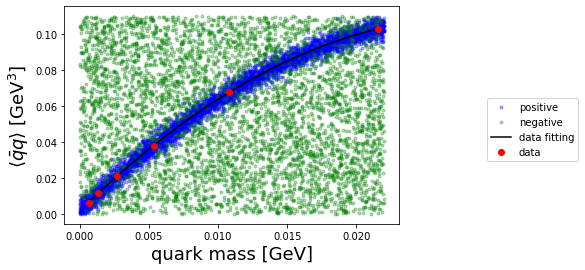

In [3]:
# data values
Hs, Ms = return_HM_npy('q-pp-highT-phys.csv') # data
# data fitting
f = np.poly1d(np.polyfit(Hs, Ms, deg=3)) # data fitting
# data augmentation (H_M_F = (x, y, 0/1) )
positive_H_M_F, negative_H_M_F = generate_training_data(data_size=5000, f=f)
# plot
plot_all(Hs, Ms, positive_H_M_F, negative_H_M_F, f)

## Reformat training data
To train a model by using PyTorch, the training data should be treated by a class called `Dataset`.

In [4]:
class Phi_Pi_DataSet(Dataset):
    ''' class for handling data '''
    def __init__(self, positive_H_M_F, negative_H_M_F, transform=None):
        self.phi = np.concatenate((positive_H_M_F[0], negative_H_M_F[0]),axis=0).astype(np.float32)
        self.Pi = np.concatenate((positive_H_M_F[1], negative_H_M_F[1]),axis=0).astype(np.float32)
        self.ans = np.concatenate((positive_H_M_F[2], negative_H_M_F[2]),axis=0).astype(np.float32)
        self.transform = transform

    def __getitem__(self, index):
        phi = self.phi[index]
        Pi = self.Pi[index]
        ans = self.ans[index]
        if self.transform is not None:
            phi = self.transform(phi)
            Pi = self.transform(Pi)
            ans = self.transform(ans)
        return phi, Pi, ans

    def __len__(self):
        return len(self.phi)

In [5]:
train_d_loader = DataLoader(Phi_Pi_DataSet(
                                           positive_H_M_F=positive_H_M_F, 
                                           negative_H_M_F=negative_H_M_F, 
                                           transform=transforms.Compose([torch.from_numpy])), 
                                           batch_size=100, shuffle=True)

# 2. Make a Neural network

Here we make the network (`Test`) and reguralization coefficients. For more details, please take a look at `network.py`.

In [6]:
# def phi_one_step(phi=None, Pi=None, del_eta=None):
#     ''' phi's eta evolution '''
#     return phi + del_eta*Pi 

# def Pi_one_step(phi=None, Pi=None, Pi_W=None, phi_m2=None, phi3_lam = None, del_eta=None):
#     ''' Pi's eta evolution '''
#     return Pi +(-1)*del_eta*(Pi_W - phi_m2 - phi3_lam)

# def one_step(phi, Pi, Pi_W=None, phi_m2=None, phi3_lam = None, del_eta=None):
#     ''' Evolutions both phi and Pi '''
#     phi2 = phi_one_step(phi, Pi, del_eta)
#     Pi2 = Pi_one_step(phi, Pi, Pi_W=Pi_W, phi_m2=phi_m2, phi3_lam = phi3_lam, del_eta=del_eta)
#     return phi2, Pi2

def onestep(phi, Pi, hh=None, m2=None, lamb=None, del_eta=None):
    phi1 = phi + del_eta*Pi
    Pi1 = phi*m2*del_eta + (1-del_eta*hh)*Pi + del_eta*lamb*(phi1**3)
    return phi1, Pi1

def eta(s, eta_ini, eta_fin, N_layer):
    eta = eta_ini + (eta_fin - eta_ini)*(s-1)/N_layer
    return eta

# functions in final layers

def f(phi, Pi, eta=None):
    ''' returning Pi'''
    F=Pi
    return F

def arctan_scaled(x, center=None, scale=10, tanh=None):
    y = scale*(x-center)
    y = tanh(y)
    return y

def t(x, epsilon=None, tanh=None, dev=.01):
    ''' smoothed bump function '''
    left = -arctan_scaled(x, center=-epsilon, scale=1/dev, tanh=tanh)
    right = arctan_scaled(x, center=epsilon, scale=1/dev, tanh=tanh)
    lf = left+right
    return (lf+2)/2

##### 

class MetricNet(nn.Module):
    ''' class of model to be trained '''
    def __init__(self, Number_of_layers=None, eta_ini=None, eta_fin=None, m2=None, del_eta=None, d=None):
        super(MetricNet, self).__init__()
        # trained parameters
        Hs = []
        for layer_index in range(Number_of_layers):
            Hs.append(nn.Linear(1, 1, bias=False))
        self.Hs = nn.ModuleList(Hs)
        self.adsradius = nn.Linear(1, 1, bias=False)
        self.lamb = nn.Linear(1, 1, bias=False)
        # fixed parameters
        self.one = Variable(torch.ones(1)) # it would be better to use torch.nn.parameter.
        self.N_layers = Number_of_layers
        self.eta_ini = eta_ini
        self.eta_fin = eta_fin
        self.m2 = m2
        self.del_eta = del_eta
        self.d = d

    def show_lamb(self):
        return self.lamb(self.one)
    
    def show_adsradius(self):
        return self.adsradius(self.one)
        
    def penalty(self, coef_list=None):
        if coef_list==None:
            coefs = torch.autograd.Variable(torch.ones(self.N_layers))
        else:
            n_coef_list = np.array(coef_list, dtype=np.float32)
            coefs = torch.autograd.Variable(torch.from_numpy(n_coef_list))
        for i in range(self.N_layers):
            H = self.Hs[i]
            if H==self.Hs[0]:
                # making the metric at boundary as AdS_{d+1} 
                penalty = 0.01*(self.d - H(self.one))**2
                pH = H(self.one)
            else:
                # smoothing penalty
                ## if Einstein equation, use below:
                #penalty = penalty + coefs[i]*(-d**2 + (H(self.one) - pH)/del_eta + pH**2)**2
                penalty = penalty + coefs[i]*(H(self.one) - pH)**2
                pH = H(self.one)
        return penalty
        
    def forward(self, phi=None, Pi=None):
        ''' forward propagation '''
        # initial layer
        alphatilde = self.adsradius(self.one)*(1.7320508/(2*3.1415926))*phi
        betatilde = (self.adsradius(self.one))**3*(3.1415926/1.7320508)*Pi
        phi = alphatilde*(np.exp(-self.eta_ini)) + betatilde*(np.exp(-3*self.eta_ini)) -(1/2)*alphatilde**3*self.lamb(self.one)*self.eta_ini*(np.exp(-3*self.eta_ini))
        Pi = -alphatilde*(np.exp(-self.eta_ini)) -3*betatilde*(np.exp(-3*self.eta_ini)) +(3/2)*alphatilde**3*self.lamb(self.one)*self.eta_ini*(np.exp(-3*self.eta_ini))-(1/2)*alphatilde**3*self.lamb(self.one)*(np.exp(-3*self.eta_ini))
        # intermediate layers
        for H in self.Hs:
            phi, Pi = onestep(phi, Pi, hh=H(self.one), m2=self.m2, lamb=self.lamb(self.one), del_eta=self.del_eta)
        # finaly layer
        f_ = f(phi, Pi, eta=eta(self.N_layers, self.eta_ini, self.eta_fin, self.N_layers))
        final = t(f_, epsilon=.1, tanh=torch.tanh)
        return final
    
    def loss(self, phi=None, Pi=None, answer=None, reg_coef_list=None):
        model_output = self.forward(phi=phi, Pi=Pi)
        loss = F.l1_loss(model_output, answer)**2
        loss = loss + self.penalty(coef_list=reg_coef_list)
        return loss

def init_weights(Model, d):
    ''' for initializations of parameters '''
    # metric (H[layer])
    for i in range(len(Model.Hs)):
        # ipt = initial value for H[i]
        ipt = d
        # noize 
        std = 3
        w = np.random.normal(ipt, std) # sampling from Gaussian
        w = round(w, 10) # it seems to be needed to round w somehow, I don't know why...
        Model.Hs[i].weight.data.fill_(w) # initialization excuted 
    
    # lambda
    lamb = 0.2
    std = 0
    lamb = np.random.normal(lamb, std)
    Model.lamb.weight.data.fill_(lamb)
    
    # AdS radius[GeV^{-1}]
    adsradius = 0.8
    std = 0
    adsradius = np.random.normal(adsradius, std)
    Model.adsradius.weight.data.fill_(adsradius)

lambda: 0.20000000298023224,   AdS radius: 0.800000011920929[1/GeV]
[ 5.282345  -0.5266322  2.288018   6.1977634  6.0502048  0.4143847
  2.7455065  2.5405319  6.213952   3.95894    8.5054455  4.8302846
  4.9904327  2.165199   4.294993 ]


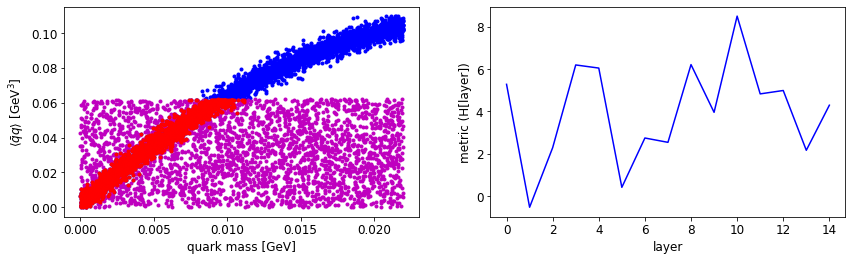

In [80]:
d = 4
m2 = -3 # mass^2
N_layer = 15
eta_fin = 1/N_layer
eta_ini = 1
del_eta = (eta_fin - eta_ini)/N_layer
Test = MetricNet(Number_of_layers=N_layer, eta_ini=eta_ini, eta_fin=eta_fin, m2=m2, del_eta=del_eta,d=d)
init_weights(Test, d)
optimizer = optim.Adam(Test.parameters()) 
Test.train()

print ("lambda: {},   AdS radius: {}[1/GeV]".format(Test.show_lamb().data.numpy()[0], Test.show_adsradius().data.numpy()[0]))
a=[Test.Hs[i](Test.one).data.numpy()[0] for i in range (Test.N_layers)]
print(np.array(a))
negx, negy, posx, posy, Hs = plot_phase_and_metric(
                                                           threshold=.1, eta_or_layer='layer',
                                                           positive_H_M_F=positive_H_M_F,
                                                           negative_H_M_F=negative_H_M_F,
                                                           Net=Test
                                                          )

# 3. Train your NN

In [15]:
def plot_phase_and_metric(threshold=None, eta_or_layer='eta', positive_H_M_F=None, negative_H_M_F=None, Net=None):
    NN2_pos_phis = []
    NN2_pos_Pis = []
    
    negative_H = negative_H_M_F[0] #input_data[1]
    negative_M = negative_H_M_F[1] #input_data[3]
    
    phis = Variable(torch.from_numpy(negative_H.astype(np.float32)))
    Pis = Variable(torch.from_numpy(negative_M.astype(np.float32)))
    NN2_predicts = Net.forward(phi=phis, Pi=Pis).data.numpy()

    for index in range(len(phis)):
        value = NN2_predicts[index]#NN2.predict([phis[index], Pis[index]])
        if value < threshold:
            NN2_pos_phis.append(negative_H[index])
            NN2_pos_Pis.append(negative_M[index])
        
    NN2_pos_phis_1 = np.array(NN2_pos_phis)
    NN2_pos_Pis_1 = np.array(NN2_pos_Pis)
    ######
    NN2_pos_phis = []
    NN2_pos_Pis = []
    
    positive_H = positive_H_M_F[0]# input_data[0]
    positive_M = positive_H_M_F[1]# input_data[2]
    
    phis = Variable(torch.from_numpy(positive_H.astype(np.float32)))
    Pis = Variable(torch.from_numpy(positive_M.astype(np.float32)))
    NN2_predicts = Net.forward(phi=phis, Pi=Pis).data.numpy()

    for index in range(len(phis)):
        value = NN2_predicts[index]#NN2.predict([phis[index], Pis[index]])
        if value < threshold:
            NN2_pos_phis.append(positive_H[index])
            NN2_pos_Pis.append(positive_M[index])
        
    NN2_pos_phis_2 = np.array(NN2_pos_phis)
    NN2_pos_Pis_2 = np.array(NN2_pos_Pis)
    ####
    plt.rcParams["font.size"] = 12
    fig = plt.figure(figsize=(14, 4))
    fig.subplots_adjust(bottom=0.15)
    al = fig.add_subplot(1,2,1)
    ar = fig.add_subplot(1,2,2)
    al.set_xlabel('quark mass [GeV]', fontsize=12)
    al.set_ylabel(r'$\langle \bar{q}q\rangle$ [GeV$^3$]', fontsize=12)
    al.plot(positive_H , positive_M, 'b.', label='Positive')
    #print(NN2_pos_phis_1)
    al.plot(NN2_pos_phis_1 , NN2_pos_Pis_1, 'm.', label='NN(negative)=0')
    al.plot(NN2_pos_phis_2 , NN2_pos_Pis_2, 'r.', label='NN(positive)=0')
    al.tick_params(labelsize=12)
    #al.legend(loc="upper left")
    ##
    if eta_or_layer=='eta':
        x = etas
        ar.set_xlabel('eta', fontsize=12)
    else:
        x = np.arange(0,Net.N_layers,1)
        ar.set_xlabel('layer', fontsize=12)
    NN2_list = []
    for param in Net.Hs.parameters():
        w_py = (param.data.numpy().reshape(-1)).tolist()
        NN2_list.append(w_py)
    ar.set_ylabel('metric (H[layer])', fontsize=12)
    ar.plot(x, np.array(NN2_list), 'b-')#label='Emergent metric',lw=5, alpha=0.5)#/NN_list[0])
    ar.tick_params(labelsize=12)
    plt.show()
    return NN2_pos_phis_1, NN2_pos_Pis_1, NN2_pos_phis_2, NN2_pos_Pis_2, NN2_list

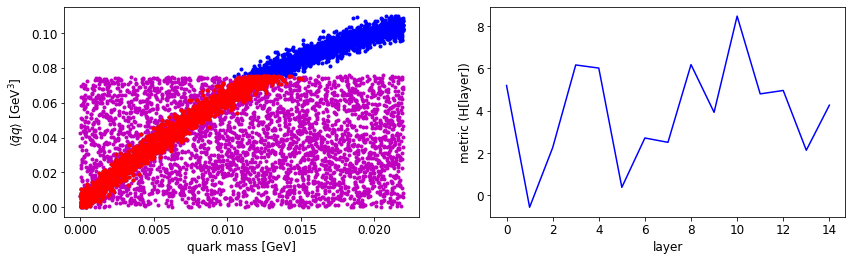

training epoch: 0,   loss: 0.32777461409568787
lambda: 0.15461774170398712,   AdS radius: 0.7617904543876648[1/GeV]
[ 5.187082   -0.5661745   2.2486575   6.1585946   6.011195    0.37550607
  2.7067862   2.5019689   6.1755586   3.9206877   8.467327    4.792268
  4.9525046   2.1273475   4.2572184 ]


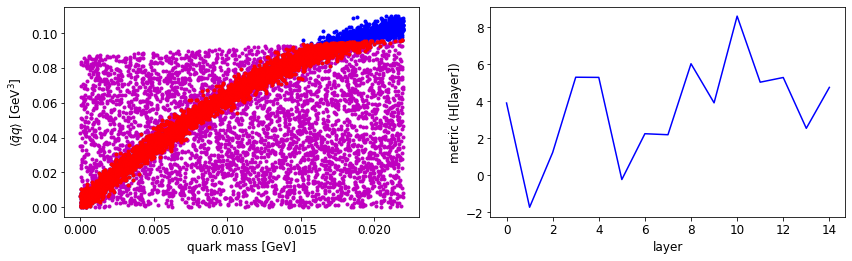

training epoch: 100,   loss: 0.23672157526016235
lambda: -2.5071420669555664,   AdS radius: 0.8705534934997559[1/GeV]
[ 3.891609   -1.7377367   1.2200271   5.2855296   5.2757506  -0.24011348
  2.2337165   2.1789155   6.0135336   3.90136     8.58594     5.0169916
  5.270519    2.525781    4.7358003 ]


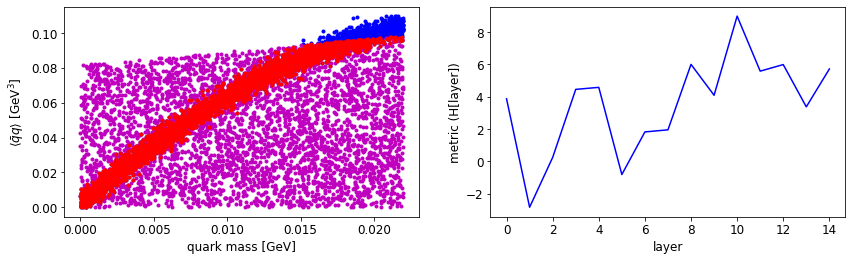

training epoch: 200,   loss: 0.22373142838478088
lambda: -5.693418025970459,   AdS radius: 1.0354868173599243[1/GeV]
[ 3.8669314  -2.8381996   0.24121767  4.4494786   4.5746274  -0.8158797
  1.8192691   1.9479692   5.9957094   4.0864253   8.979305    5.5778737
  5.9825864   3.3693955   5.710409  ]


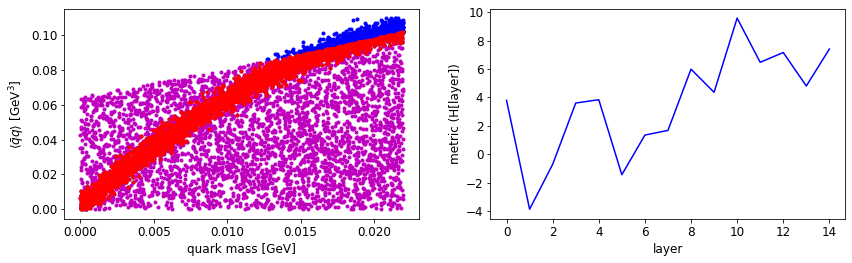

training epoch: 300,   loss: 0.18997782468795776
lambda: -9.83082103729248,   AdS radius: 1.4854133129119873[1/GeV]
[ 3.7910175  -3.8748293  -0.71279496  3.6023643   3.836292   -1.445104
  1.3470634   1.6753656   5.9857297   4.35958     9.580367    6.470973
  7.1584563   4.802088    7.402839  ]


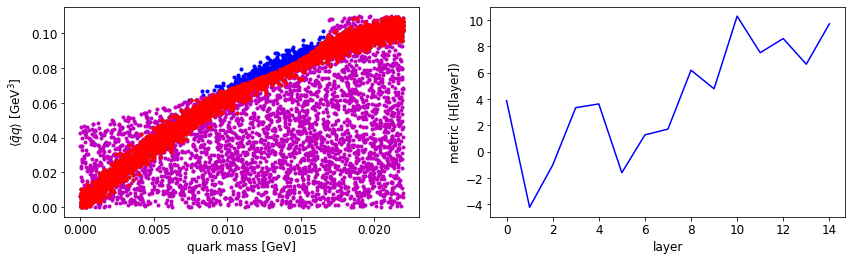

training epoch: 400,   loss: 0.16046012938022614
lambda: -9.827268600463867,   AdS radius: 1.7081925868988037[1/GeV]
[ 3.8771234 -4.227549  -1.0264206  3.3374927  3.6234138 -1.6030614
  1.2693264  1.7088934  6.1860337  4.77348   10.295524   7.5169277
  8.589133   6.6417847  9.705995 ]


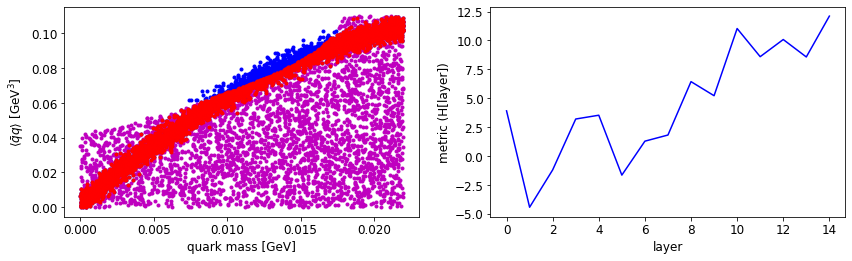

training epoch: 500,   loss: 0.14818376302719116
lambda: -9.097759246826172,   AdS radius: 1.668508768081665[1/GeV]
[ 3.9028394 -4.4394846 -1.2063041  3.1964347  3.5240302 -1.6580043
  1.2790004  1.8104317  6.4311013  5.21316   11.027788   8.59116
 10.07536    8.566413  12.101069 ]


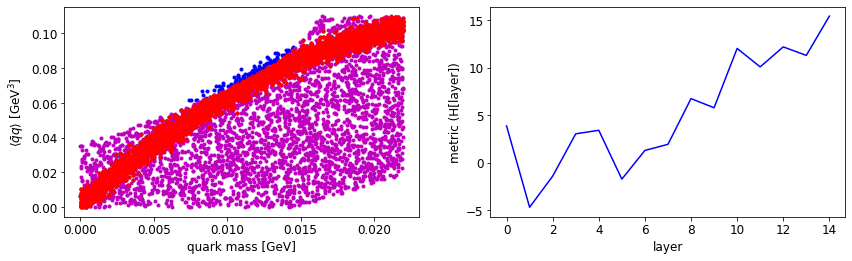

training epoch: 600,   loss: 0.12864291667938232
lambda: -7.881072998046875,   AdS radius: 1.6370429992675781[1/GeV]
[ 3.870824  -4.6709332 -1.403059   3.0423243  3.4163616 -1.7153382
  1.2972212  1.939911   6.7424355  5.784275  12.011501  10.079405
 12.174374  11.284058  15.40997  ]


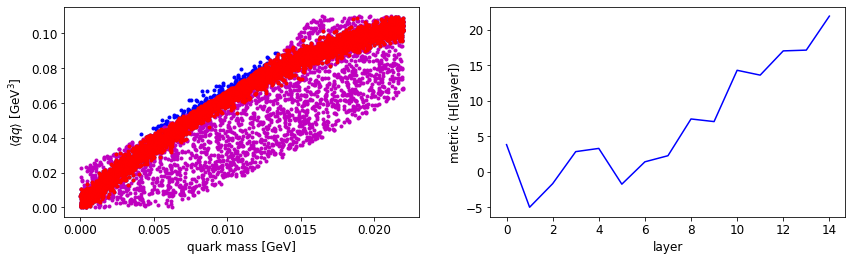

training epoch: 700,   loss: 0.061021093279123306
lambda: -4.355677127838135,   AdS radius: 1.6390678882598877[1/GeV]
[ 3.8020523 -5.026939  -1.7019066  2.815429   3.2696095 -1.7729259
  1.3796751  2.2394922  7.422119   7.052418  14.287624  13.604956
 17.02258   17.131163  21.926514 ]


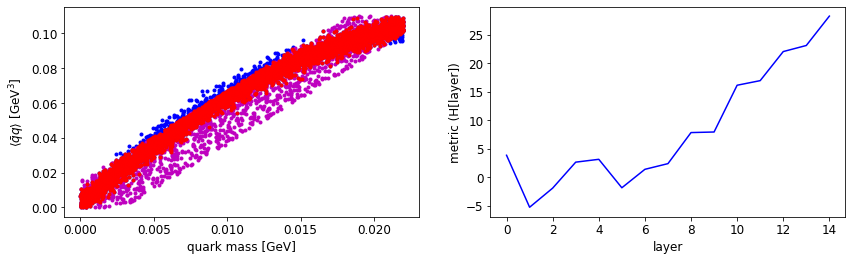

training epoch: 800,   loss: 0.017129478976130486
lambda: -0.1407320201396942,   AdS radius: 1.7514936923980713[1/GeV]
[ 3.8713722 -5.2466083 -1.8921692  2.663446   3.161571  -1.8304123
  1.4056969  2.4035878  7.851381   7.951482  16.155748  16.962353
 22.061583  23.129087  28.280703 ]


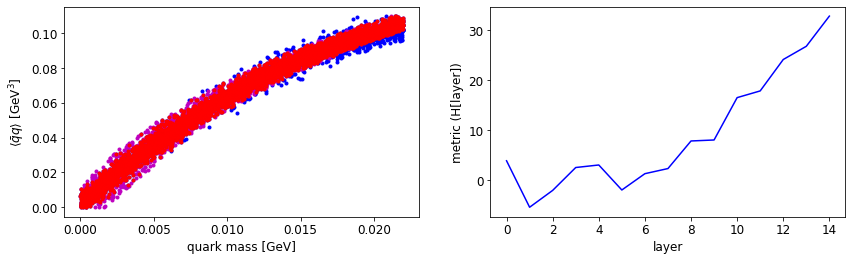

training epoch: 900,   loss: 0.00677139637991786
lambda: 0.7279358506202698,   AdS radius: 2.132131814956665[1/GeV]
[ 3.9285455 -5.332683  -1.974756   2.5861785  3.0907843 -1.8933359
  1.3567187  2.3790023  7.876635   8.073752  16.51669   17.853464
 24.113508  26.748158  32.763306 ]


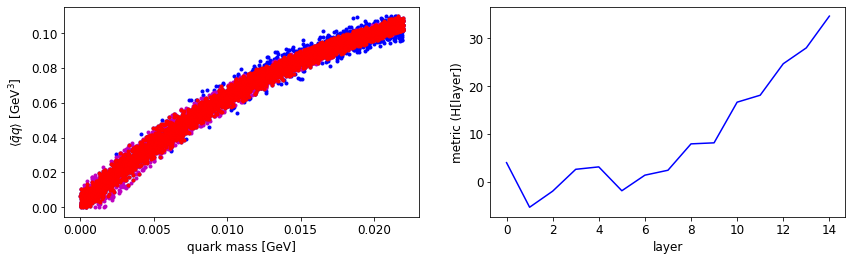

training epoch: 1000,   loss: 0.006001153960824013
lambda: 0.7102811932563782,   AdS radius: 2.139599084854126[1/GeV]
[ 3.9678235 -5.342069  -1.9832765  2.5788238  3.084868  -1.8975351
  1.3552566  2.3822815  7.8894906  8.105428  16.595972  18.047411
 24.618814  27.934088  34.563835 ]


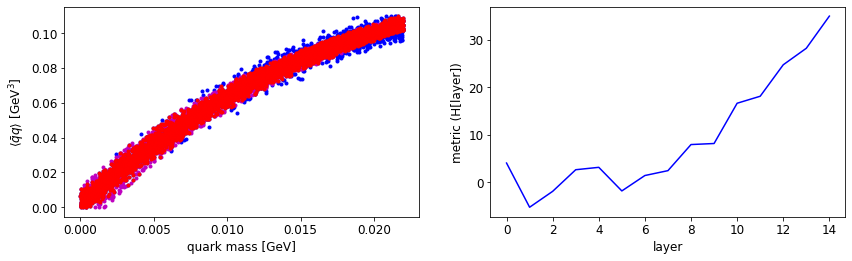

training epoch: 1100,   loss: 0.006540920119732618
lambda: 0.7346521019935608,   AdS radius: 2.125969171524048[1/GeV]
[ 3.9851935 -5.345158  -1.9861252  2.5762959  3.0827668 -1.8991201
  1.3543302  2.382469   7.8918295  8.1120405 16.613113  18.090326
 24.73419   28.219662  35.008987 ]


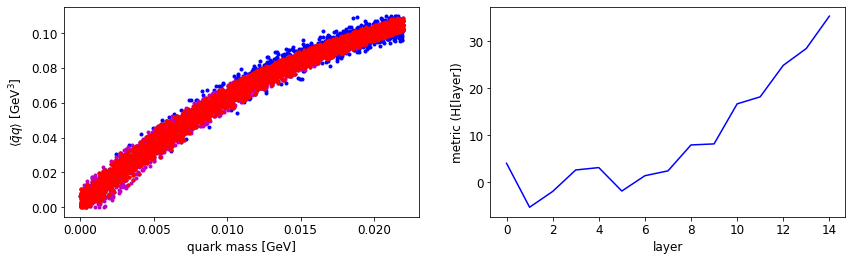

training epoch: 1200,   loss: 0.006023721769452095
lambda: 0.7683650255203247,   AdS radius: 2.113715648651123[1/GeV]
[ 3.9936378 -5.3459015 -1.9866687  2.575977   3.0827565 -1.8987442
  1.3551304  2.3840065  7.8947372  8.117603  16.625216  18.118479
 24.807083  28.39526   35.276882 ]


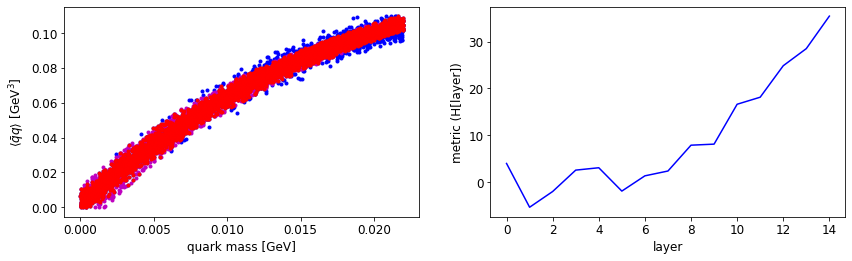

training epoch: 1300,   loss: 0.006097255274653435
lambda: 0.8032842874526978,   AdS radius: 2.097921848297119[1/GeV]
[ 3.9968326 -5.3468986 -1.9875226  2.5752983  3.0823426 -1.8988559
  1.3553358  2.3847108  7.896314   8.120955  16.632742  18.136168
 24.852928  28.504492  35.4412   ]


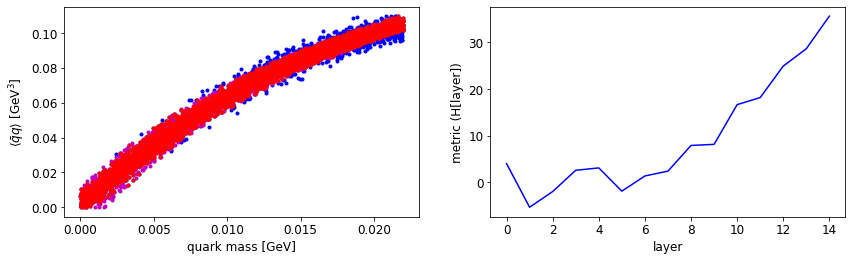

training epoch: 1400,   loss: 0.006223362870514393
lambda: 0.8480456471443176,   AdS radius: 2.0886878967285156[1/GeV]
[ 3.9978802 -5.3477454 -1.988245   2.5747316  3.0820296 -1.898859
  1.3556322  2.385512   7.89804    8.124493  16.640556  18.15455
 24.900581  28.618885  35.612007 ]


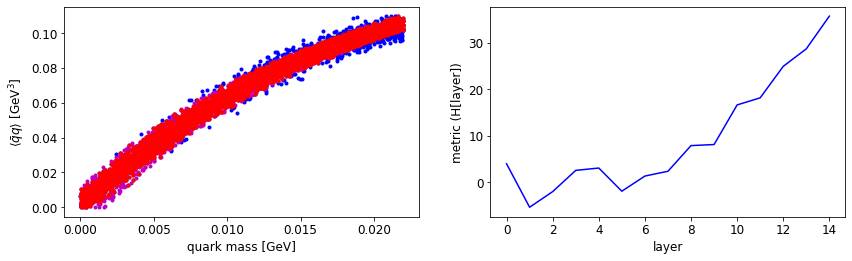

training epoch: 1500,   loss: 0.018503732979297638
lambda: 0.8848523497581482,   AdS radius: 2.0732760429382324[1/GeV]
[ 3.9980764 -5.3469806 -1.9878715  2.5750494  3.082595  -1.8976114
  1.3568466  2.3873024  7.900205   8.128454  16.64684   18.169191
 24.935204  28.701273  35.73312  ]


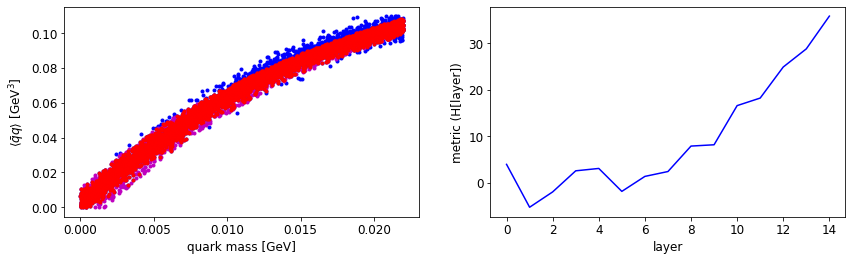

training epoch: 1600,   loss: 0.01831229031085968
lambda: 0.9260131120681763,   AdS radius: 2.065211296081543[1/GeV]
[ 3.9397104 -5.2917852 -1.9892573  2.5498343  3.0610268 -1.8771112
  1.3474183  2.3957422  7.875405   8.15654   16.585232  18.209234
 24.895739  28.799969  35.850784 ]


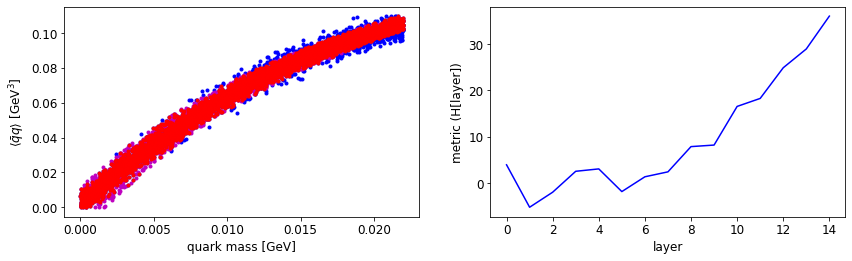

training epoch: 1700,   loss: 0.01873263157904148
lambda: 0.9626939296722412,   AdS radius: 2.0514681339263916[1/GeV]
[ 3.913068  -5.245501  -1.9991041  2.5161495  3.0309837 -1.8652946
  1.3296721  2.3957365  7.8428845  8.17651   16.51899   18.244917
 24.866209  28.923275  36.012108 ]


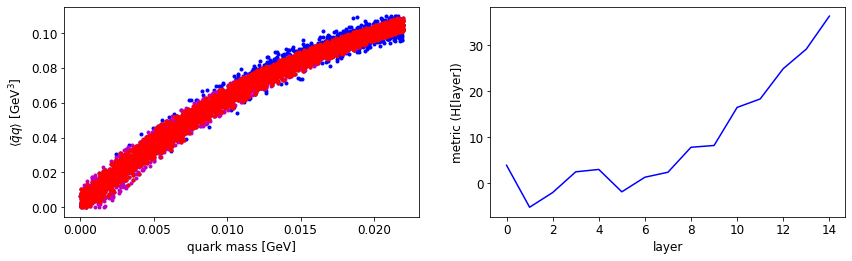

training epoch: 1800,   loss: 0.01820976473391056
lambda: 1.0020549297332764,   AdS radius: 2.0453476905822754[1/GeV]
[ 3.9035513 -5.1974535 -2.0083191  2.4824586  3.0010593 -1.8525403
  1.3124971  2.396686   7.811384   8.198868  16.456854  18.289495
 24.862267  29.103407  36.258865 ]


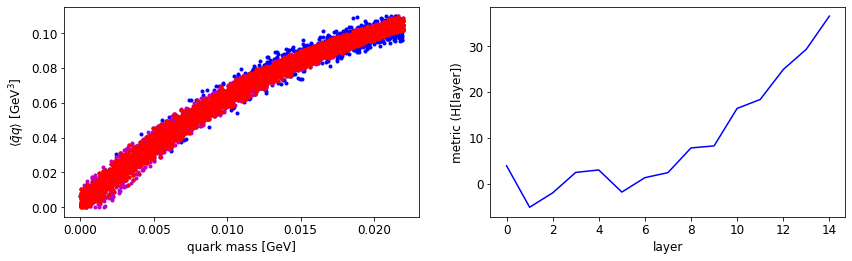

training epoch: 1900,   loss: 0.01756490021944046
lambda: 1.0382437705993652,   AdS radius: 2.0329251289367676[1/GeV]
[ 3.8994288 -5.151496  -2.0189354  2.4475129  2.9698706 -1.8416073
  1.2940011  2.3959134  7.778878   8.218903  16.39491   18.330788
 24.85908   29.28169   36.508217 ]


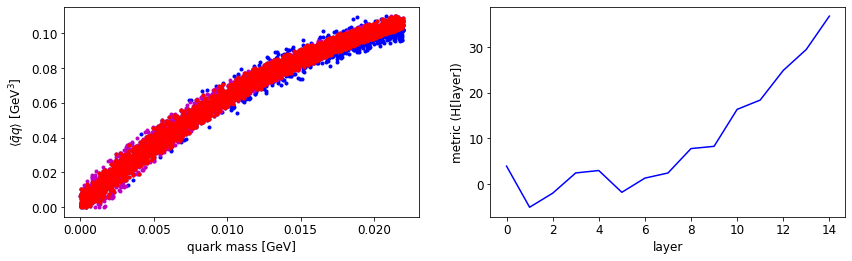

training epoch: 2000,   loss: 0.017730148509144783
lambda: 1.073818564414978,   AdS radius: 2.0206692218780518[1/GeV]
[ 3.8969276 -5.1060996 -2.0304887  2.4113061  2.9374425 -1.8317549
  1.2744248  2.393972   7.745347   8.237717  16.332924  18.370605
 24.858414  29.460115  36.760387 ]


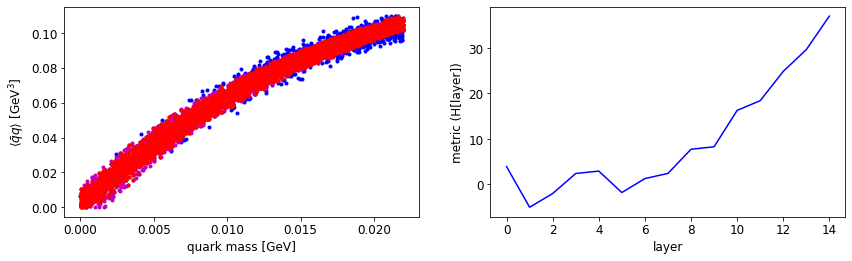

training epoch: 2100,   loss: 0.01742387004196644
lambda: 1.1138445138931274,   AdS radius: 2.013056755065918[1/GeV]
[ 3.897722  -5.0582657 -2.0399525  2.376911   2.9068496 -1.8198999
  1.2568729  2.3940322  7.714123   8.258793  16.27515   18.414644
 24.870232  29.659246  37.044563 ]


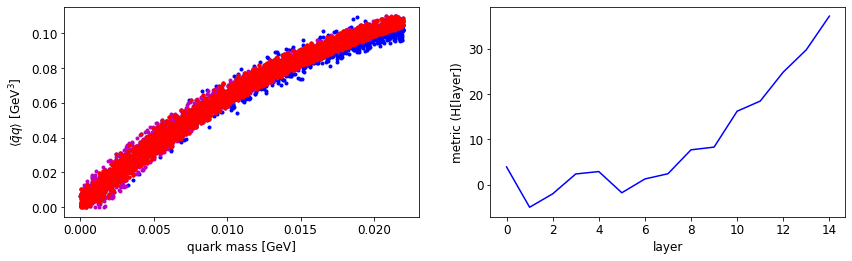

training epoch: 2200,   loss: 0.01755773462355137
lambda: 1.1518887281417847,   AdS radius: 2.0005171298980713[1/GeV]
[ 3.8964698 -5.0124407 -2.0517225  2.3398917  2.8735852 -1.8107519
  1.23655    2.390942   7.6794863  8.274991  16.211142  18.444275
 24.853434  29.786833  37.22807  ]


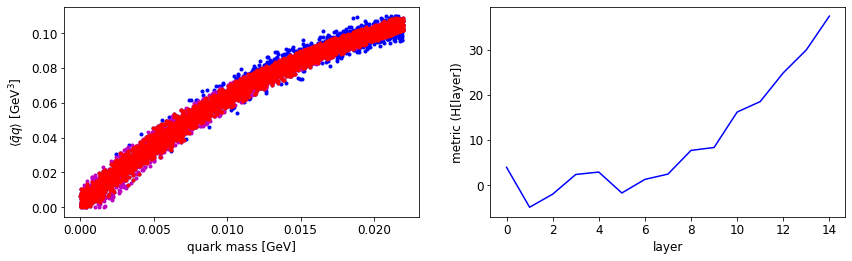

training epoch: 2300,   loss: 0.017267771065235138
lambda: 1.193150281906128,   AdS radius: 1.993658423423767[1/GeV]
[ 3.8992906 -4.962658  -2.0593674  2.306944   2.8444002 -1.7977566
  1.220381   2.3918195  7.649419   8.295281  16.153929  18.480024
 24.851797  29.936735  37.441597 ]


In [ ]:
total_epoch=6000
show_epoch_each=100

for epoch in range(total_epoch):
    if epoch==0:
        regularization_coeffs = [0]
        for i in range(1, N_layer):
            regularization_coeffs.append(0.0*eta(i, eta_ini, eta_fin, N_layer)**4)
    if epoch==1500:
        regularization_coeffs = [0]
        for i in range(1, N_layer):
            regularization_coeffs.append(0.0001*eta(i, eta_ini, eta_fin, N_layer)**4)
    if epoch==3000:
        regularization_coeffs = [0]
        for i in range(1, N_layer):
            regularization_coeffs.append(0.001*eta(i, eta_ini, eta_fin, N_layer)**4)
    if epoch==4500:
        regularization_coeffs = [0]
        for i in range(1, N_layer):
            regularization_coeffs.append(0.01*eta(i, eta_ini, eta_fin, N_layer)**4)
    batches = iter(train_d_loader)
    train_loss = 0.0
    for (b_phi, b_Pi, b_ans) in batches:
        # (b_phi, b_Pi, b_ans) is a minibatch, we need to convert it to `Variable` object. 
        phi, Pi, ans = Variable(b_phi), Variable(b_Pi), Variable(b_ans)
        # calclation of loss
        loss = Test.loss(phi=phi, Pi=Pi, answer=ans, reg_coef_list=regularization_coeffs)
        # update
        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()
        train_loss += loss.data[0]
    if np.isnan(train_loss)==True: break

    if epoch % show_epoch_each == 0:
        negx, negy, posx, posy, Hs = plot_phase_and_metric(
                                                           threshold=.1, eta_or_layer='layer',
                                                           positive_H_M_F=positive_H_M_F,
                                                           negative_H_M_F=negative_H_M_F,
                                                           Net=Test
                                                          )
        print ("training epoch: {},   loss: {}".format(epoch, train_loss / len(train_d_loader)))
        print ("lambda: {},   AdS radius: {}[1/GeV]".format(Test.show_lamb().data.numpy()[0], Test.show_adsradius().data.numpy()[0]))
        print(np.array([Test.Hs[i](Test.one).data.numpy()[0] for i in range (Test.N_layers)]))

In [ ]:
a=[Test.Hs[i](Test.one).data.numpy()[0] for i in range (Test.N_layers)]
print(np.array(a))
print(c_reg1)

# 4. Save & load NN

Create a directry named "trained_models" by running the following cell:

In [ ]:
%%bash
mkdir trained_models

Instance "Test" of the trained MetricNet is saved there by using `torch.save`.

In [ ]:
torch.save(Test, 'trained_models/name.pt') 

To load a saved model, use `torch.load`.

In [ ]:
model = torch.load('trained_models/name.pt')

# 5. How to get trained parameters of the NN

To get the parameters as numpy array, use:

In [ ]:
model.adsradius.weight.data.numpy() # AdS radius in unit [GeV^{-1}]

In [ ]:
model.lamb.weight.data.numpy() # lambda

In [ ]:
for h in model.Hs:     # metric (h)
    np_h = h.weight.data.numpy()
    print(np_h)